# Naive Bayes i Classificació


En aquest tercer lliurament es programarà un classificador, que donat un tweet el categoritzarà en una de les possibles classes. En aquesta ocasió, implementareu un classificador amb tweets de polítics.


**Què s’ha de fer?**

Volem classificar tweets corresponents a diferents politics segons a quin partit polític pertanyen. 
A partir de tots els tweets que tenim, crearem un vector de característiques que ens descrigui cada un dels tweets. 
Finalment desenvoluparem un classificador probabilístic del tipus Naive Bayes que ens permeti identificar a quin partit polític pertany un tweet donat segons les característiques triades.


**Quina és la idea del sistema de classificació que s’ha de desenvolupar?**

El classificador és un concepte de l'aprenentatge automàtic supervisat. 
L'objectiu del classificador és donat un vector de característiques que descriuen els objectes que es volen classificar indicar a quina categoria o classe pertanyen d'entre un conjunt predeterminat. 
El procés de classificació consta de dues parts: 
(a) el procés d'aprenentatge i 
(b) el procés d'explotació o testeig. 
El procés d'aprenentatge rep exemples de parelles $(x,y)$ on $x$ són les característiques, usualment nombres reals, i $y$ és la categoria a la que pertanyen. 
Aquest conjunt se'l coneix com a conjunt d'entrenament i ens servirà per trobar una funció $\hat{y}=h(x)$ que donada una $x$ aconsegueixi que $\hat{y}=y$. Per altra banda el procés de testeig aplica la funció $h(x)$ apresa a l'entrenament a una nova descripció per veure quina categoria li correspon.


**Classificació i llenguatge natural**

La descripció dels exemples en característiques és el punt més crític de tot sistema d'aprenentatge automàtic. 
Una de les representacions més simples per tal de descriure un text és la representació *bag-of-words*.
Aquesta representació converteix un text en un vector de $N$ paraules. 
Consisteix en seleccionar un conjunt d'$N$ paraules i per cada paraula comptar quants cops apareix en el text. 
Una versió alternativa d'aquest procés pot ser simplement indicar si apareix o no en el text.

## Abans de començar


**\+ Durant la pràctica, solament es podran fer servir les següents llibreries**:

`Pandas, Numpy` i `NLTK`

*Nota: A més de les que ja es troben presents en la 1a cel·la i funcions natives de Python*

**\+ No es poden modificar les definicions de les funcions donades, ni canviar els noms de les variables i paràmetres ja donats**

Això no implica però que els hàgiu de fer servir. És a dir, que la funció tingui un paràmetre anomenat `df` no implica que l'hàgiu de fer servir, si no ho trobeu convenient.

**\+ En les funcions, s'especifica què serà i de quin tipus cada un dels paràmetres, cal respectar-ho**

Per exemple (ho posarà en el pydoc de la funció), `df` sempre serà indicatiu del `Pandas.DataFrame` de les dades. 

# Preparar les dades

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import zipfile
import pickle
from os.path import join as path, dirname

try:
    from IPython.core.display import HTML

    def pprint(df):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(HTML(pd.DataFrame(df).to_html()))
except:
    def pprint(df):
        print(df)

In [3]:
print('Training data')
df_tweets_train = pd.read_excel(path('data', 'train.xlsx'), index_col='Id')
pprint(df_tweets_train.head())
print(df_tweets_train.shape)

print('Test data')
df_tweets_test = pd.read_excel(path('data', 'test.xlsx'), index_col='Id')
pprint(df_tweets_test.head())
print(df_tweets_test.shape)

Training data


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
0,martarovira,erc,Últim acte de campanya! Aquí tossudament alçat...,2017-12-19 20:12:01,785,2295
1,xavierdomenechs,comuns,#Badalona necessita uns pressupostos que posin...,2018-04-27 10:04:19,55,93
2,albert_rivera,cs,Encuentro Villacís-Valls para lanzar una estra...,2018-11-17 20:34:58,357,622
3,jaumecollboni,psc,"“La palabra es como una bala, no tiene retorno...",2018-10-22 18:10:01,4,6
4,albiol_xg,ppc,"📻 Esta noche, a partir de las 22:10h, me entre...",2018-08-16 10:30:27,20,47


(1920, 6)
Test data


,text,retweet_count,favorite_count
Id,,,
0,Avui hem représ la Comissió Mixta amb el @gove...,67,103
1,"Torra anunció un ""otoño caliente"" para aumenta...",856,1501
2,Demà cal sortir als carrers per dir que #Barce...,144,174
3,“Cercàvem or i vam baixar a la mina.\nI la fos...,338,1560
4,"Molt senzill d'entendre, companya: \n1.- L'ALL...",4932,7253


(480, 3)


# Implementació

Dividirem el notebook en 3 seccions que es complementen una a l'altra:

1. Anàlisis de dades: Informació bàsica sobre els tweets
2. Processament de les dades: Creació d'un vector de característiques a partir dels tweets
3. Classificació amb Naive Bayes

### Anàlisis de dades

El primer que haurem de fer és analitzar les dades mitjançant diferents funcions.

In [4]:
def count_tweets(df):
    """
    Retorna el número de tweets en el dataframe
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : número de tweets
    """
    #len(df.index)
    return df.shape[0]

def get_politicians(df):
    """
    Retorna els usuaris dels polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb els nom dels usuaris
    """
    return df['username'].unique().tolist() #devuelve todos los nombres sin repeticiones

def count_politicians(df):
    """
    Retorna la quantitat de polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    return df['username'].nunique() #no contamos mas de una vez nunca a un mismo politico aunque haya tuiteado varias veces

def get_political_party(df):
    """
    Retorna els partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb els nom dels partits polítics que han tuitejat
    """
    return df['party'].unique().tolist()

def count_political_party(df):
    """
    Retorna la quantitat de partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    return df['party'].nunique()

def count_tweet_politician(df):
    """
    Retorna la quantitat de tweets per polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Series amb la quantitat de tweets per polític
    """
    return df['username'].groupby(df['username']).count() #agrupamos por usuariamos y contamos los tuits para cada uno de estos

def count_tweet_party(df):
    """
    Retorna la quantitat de tweets per partit polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Series amb la quantitat de tweets per partit polític
    """
    return df['party'].groupby(df['party']).count()

def top_retweet(df, n):
    """
    Retorna els n tweets que han sigut més retuitejats
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Series amb els top retweets
    """
    return df.nlargest(n,'retweet_count')
    
def top_favorite(df, n):
    """
    Retorna els n tweets més favorits
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Series amb els top favorits
    """
    return df.nlargest(n,'favorite_count')

1920
['martarovira', 'xavierdomenechs', 'albert_rivera', 'jaumecollboni', 'albiol_xg', 'miqueliceta', 'quimtorraipla', 'adacolau', 'santirodriguez', 'krls', 'joantarda', 'inesarrimadas'] 12
['erc', 'comuns', 'cs', 'psc', 'ppc', 'jxcat'] 6


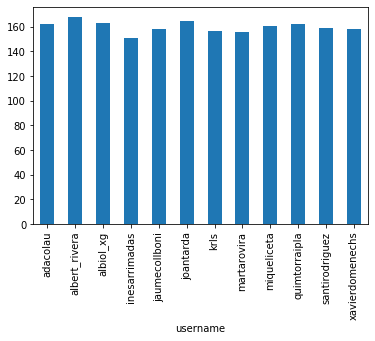

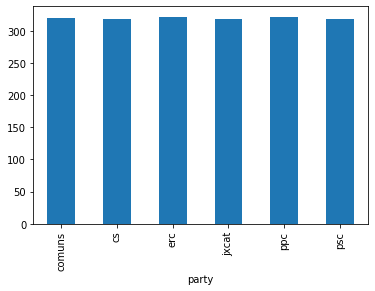

,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
907,adacolau,comuns,Que una republicana defienda la República es b...,2018-10-26 22:17:38,11706,26838
781,martarovira,erc,A tots els demòcrates: no pararem fins que tor...,2017-11-02 17:42:06,10403,19991
138,krls,jxcat,Una causa que necessiti ser defensada amb cúte...,2018-08-29 20:21:30,10086,20357
1664,martarovira,erc,.@junqueras President d'un partit amb 86 anys ...,2017-12-13 21:17:18,9445,15947
1515,krls,jxcat,"Perdoneu, però això és tan greu que si no hi h...",2018-09-19 20:16:22,8806,12509


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
907,adacolau,comuns,Que una republicana defienda la República es b...,2018-10-26 22:17:38,11706,26838
138,krls,jxcat,Una causa que necessiti ser defensada amb cúte...,2018-08-29 20:21:30,10086,20357
174,krls,jxcat,Acabo d'arribar a #Escòcia convidat pel Fòrum ...,2018-08-24 17:55:01,6783,20018
781,martarovira,erc,A tots els demòcrates: no pararem fins que tor...,2017-11-02 17:42:06,10403,19991
1043,krls,jxcat,Una gran #Diada2018 per avançar cap a la repúb...,2018-09-11 18:48:43,6372,18950


In [5]:
print(count_tweets(df_tweets_train))
print(get_politicians(df_tweets_train), count_politicians(df_tweets_train))
print(get_political_party(df_tweets_train), count_political_party(df_tweets_train))

count_tweet_politician(df_tweets_train).plot.bar()
plt.show()

count_tweet_party(df_tweets_train).plot.bar()
plt.show()

pprint(top_retweet(df_tweets_train, 5))
pprint(top_favorite(df_tweets_train, 5))

### Comptar paraules

El primer que haurem d'implementar és la funció *normalize* que normalitzarà les paraules.

No modificar la següent cel·la, s'encarrega de guardar una caché de la funció normalize per accelerar el procés.

In [6]:
def memo(f):
    class memodict(dict):
        def __init__(self, f):
            self.f = f
        def __call__(self, *args):
            return self[args]
        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret
        
    return memodict(f)

In [35]:
import unicodedata
import emoji

@memo
def normalize(word):
    """
    Funció que donada una paraula la normalitzi
    Exemple: inFO*RmÀ745tica? ---> informatica
    
    :param word: paraula a normalitzar
    :return : paraula normalitzada
    """
    normalized = ""
    #word = unicodedata.normalize('NFD', word).encode('ascii', 'ignore').decode("utf-8") #eliminamos todos los acentos
    
    
    for c in word:
        if c in emoji.UNICODE_EMOJI:
            normalized += c
            
        elif not c.isalpha(): #si no es una letra pasamos al siguiente caracter
            continue
            
        c = unicodedata.normalize('NFD', c).encode('ascii', 'ignore').decode("utf-8")
        if c.islower(): #si esta en minuscula lo añadimos a la cadena resultante
            normalized += c
        else:
            normalized += c.lower() #si no lo esta, añadimos su equivalente en minuscula
    
    return normalized

normalize('📻inFO*R🤔mÀ745tïca?')
#normalize('fこrんanにçちaiseは') comprobamos que los caracteres de otros alfabetos no son validos
#normalize('t中国nui')

'📻infor🤔matica'

In [38]:
def sentence_to_words(sentence):
    """
    Funció que donada una frase, generi una llista amb totes les seves paraules normalitzades.
    
    :param sentence: frase a transformar
    :return : llista de paraules (no buides) normalitzades
    
    Exemple: **Taller DELS noUS U**SOS    de la inFO#Rm765Àtica? ---> 
        ['taller', 'dels', 'nous', 'usos', 'de', 'la', 'informatica']
    """
    
    #para cada palabra comprobaremos si alguno de sus caracteres es un letra si no tiene letras no nos interesa normalizarla pues añadiriamos un elemento vacio a la lista
    return [normalize(word) for word in sentence.split() if any(letter.isalpha() or letter in emoji.UNICODE_EMOJI for letter in word)] #con split convertimos la cadena inicial en una lista de palabras
                                                                          

sentence_to_words('** Taller DE📻LS noUS U**SOS  📻   de la inFO#Rm765Àtica?')

['taller', 'de📻ls', 'nous', 'usos', '📻', 'de', 'la', 'informatica']

In [39]:
def count_words(df):
    """
    Funció que ha de construir un DataFrame amb índex les paraules normalitzades,
    i columnes n_ocur (nombre de vegades que apareix la paraula a tots els tweets)
    i n_tweets (nombre de tweets on apareix la paraula alguna vegada).
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame especificat.
    """
    data = dict() #diccionario que contendra los datos del dataframe siendo las columnas las claves del mismo
    
    for tweet in df['text']:
        tweets = dict()
        for word in sentence_to_words(tweet):
            tweets[word] = tweets.get(word,0)+1
        for word,ocurrences in tweets.items():
            total,tweet_wise = data.get(word,(0,0))
            data[word] = (total+ocurrences,tweet_wise+1)
            
        
    return pd.DataFrame.from_dict(data, columns =['n_ocur', 'n_tweets'], orient = 'index').sort_values(by= 'n_ocur', ascending=False)

In [40]:
counts = count_words(df_tweets_train)
#print(counts['n_ocur']['de'])
counts.head()

,n_ocur,n_tweets
de,2816,1403
la,2410,1293
a,1729,1094
el,1499,990
que,1445,921


### Contar paraules per partit polític

In [41]:
def count_words_parties(df):
    """
    Funció que ha de construir un DataFrame amb columnes les paraules normalitzades,
    i índex cadascún dels partits, contenint el nombre de vegades que cada paraula
    ha aparegut a tweets del partit.

    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame esmentat.
    """
    # @95s
    # Obtenemos un set con todas las palabras existentes en el df
    df2 = df.copy()
    df2["tokens"] = df2['text'].apply(lambda a: sentence_to_words(a))
    all_words = df2["tokens"].values # Lista que contiene una lista con las palabras
    all_words = set(sum(all_words,[])) # Concatenar en lista unica
    all_words.remove("") # Por alguna razón sentence_to_words crea un ""

    # Finalmente creamos el diccionario con las ocurrencias de cada palabra por partido
    parties = get_political_party(df2) # Lista de partidos
    # Para cada partido obtenemos sus textos y contamos la ocurrencia de cada palabra
    # en todos sus textos de forma vectorizada
    count_words_dict = {}
    for party in parties:
        df3 = df2[df2["party"] == party]
        joinText = np.concatenate(df3["tokens"].tolist()).tolist()
        count_words_dict[party] = {word:joinText.count(word) for word in all_words}

    # Creamos df y Hacemos transpuesta para tener el formato deseado
    new_df = pd.DataFrame.from_dict(count_words_dict).T
    #new_df = new_df[sorted(new_df.columns)]
    return new_df

words_parties = count_words_parties(df_tweets_train)
words_parties

,a,aacgd,aavvfront,abaixem,abandonada,abandonado,abandonar,abandonarem,abandone,abandono,...,🚓👮🏽♀👮🏻♂🏡,🚔👮🏼♀👮🏽♂👮🏻♀👮🏻♂👇🏼,🛒👇🏼,🛬,🤔,🤔😂,🤗,🤗🤗,🤣,🥉🇪🇸👏🏼
erc,292,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
comuns,330,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
cs,372,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
psc,204,0,0,0,1,0,1,0,0,0,...,1,1,1,0,0,0,0,0,0,1
ppc,248,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
jxcat,283,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Paraules més freqüents als tweets


**El problema de com escollir el vector de carecterístiques**

L'elecció de les paraules que formen el vector de característiques és un pas crític. 
En funció de com de bona sigui aquesta descripció, millor funcionarà el sistema. 
Tot i que us deixem a vosaltres la política de creació del vector de característiques us donem una d'exemple. 
Per saber quines paraules fer servir una possible estratègia és agafar aquelles paraules que apareixen entre en un 10 i un 50 percent del total (sense tenir en compte el partit). 
Podeu experimentar variant aquests valors.

In [42]:
# depèn de vosaltres emplenar aquesta llista amb possibles paraules a excloure
skip_words = ["fer","als","dels","a","abans","abans-d'ahir","abintestat","aci","adesiara","ades","adeu","adagio","ah","ahir","ai","aitambe","aitampoc","aitan","aitant","aitantost","aixa","aixo","aixi","aleshores","algun","alguna","algunes","alguns","algu","alhora","alla","allen","allo","alli","almenys","alto","altra","altre","altres","altresi","altri","alca","al·legro","amargament","amb","ambdues","ambdos","amunt","amen","anc","andante","andantino","anit","ans","antany","apa","apres","aqueix","aqueixa","aqueixes","aqueixos","aqueixs","aquell","aquella","aquelles","aquells","aquest","aquesta","aquestes","aquests","aquen","aqui","ara","arran","arrera","arrere","arreu","arri","arruix","atxim","au","avall","avant","aviat","avui","aco","bah","baix","baldament","ballmanetes","banzim-banzam","bastant","bastants","ben","bis","bitllo-bitllo","bo","be","ca","cada","cal","cap","car","caram","catorze","cent","centes","cents","cerca","cert","certa","certes","certs","cinc","cinquanta","cinquena","cinquenes","cinquens","cinque","com","comsevulla","contra","cordons","corrents","cric-crac","d","daixonses","daixo","dallonses","dallo","dalt","daltabaix","damunt","darrera","darrere","davall","davant","de","debades","dedins","defora","dejorn","dejus","della","dementre","dempeus","demes","dema","des","desena","desenes","desens","despres","dessobre","dessota","dessus","dese","deu","devers","devora","deca","diferents","dinou","dins","dintre","disset","divers","diversa","diverses","diversos","divuit","doncs","dos","dotze","dues","durant","ecs","eh","el","ela","elis","ell","ella","elles","ells","els","em","empero","en","enans","enant","encara","encontinent","endalt","endarrera","endarrere","endavant","endebades","endemig","endemes","endema","endins","endintre","enfora","engir","enguany","enguanyasses","enjus","enlaire","enlloc","enlla","enrera","enrere","ens","ensems","ensota","ensus","entorn","entre","entremig","entretant","entro","envers","envides","environs","enviro","enca","ep","ep","era","eren","eres","ergo","es","escar","essent","esser","est","esta","estada","estades","estan","estant","estar","estaran","estarem","estareu","estaria","estarien","estaries","estare","estara","estaras","estariem","estarieu","estat","estats","estava","estaven","estaves","estem","estes","esteu","estic","estiguem","estigueren","estigueres","estigues","estiguessis","estigueu","estigui","estiguin","estiguis","estigue","estiguerem","estiguereu","estigues","estigui","estos","esta","estas","estavem","estaveu","et","etc","etcetera","ets","excepte","fins","fora","foren","fores","forca","fos","fossin","fossis","fou","fra","fui","fora","forem","foreu","foreu","fossim","fossiu","gaire","gairebe","gaires","gens","girientorn","gratis","ha","hagi","hagin","hagis","haguda","hagudes","hagueren","hagueres","haguessin","haguessis","hagut","haguts","hague","haguerem","haguereu","hagues","haguessim","haguessiu","hagui","hala","han","has","hauran","haurem","haureu","hauria","haurien","hauries","haure","haura","hauras","hauriem","haurieu","havem","havent","haver","haveu","havia","havien","havies","haviem","havieu","he","hem","heu","hi","ho","hom","hui","hagim","hagiu","i","igual","iguals","inclusive","ja","jamai","jo","l","la","leri-leri","les","li","lla","llavors","llevat","lluny","llur","llurs","lo","los","ls","m","ma","mai","mal","malament","malgrat","manco","mant","manta","mantes","mantinent","mants","massa","mateix","mateixa","mateixes","mateixos","me","mentre","mentrestant","menys","mes","meu","meua","meues","meus","meva","meves","mi","mig","mil","mitges","mitja","mitjancant","mitjos","moixoni","molt","molta","moltes","molts","mon","mos","mes","n","na","ne","ni","ningu","no","nogensmenys","nomes","noranta","nos","nosaltres","nostra","nostre","nostres","nou","novena","novenes","novens","nove","ns","nos","nos","o","oh","oi","oida","on","onsevulga","onsevulla","onze","pas","pengim-penjam","per","perque","pertot","pero","piano","pla","poc","poca","pocs","poques","potser","prest","primer","primera","primeres","primers","pro","prompte","prop","prou","puix","pus","passim","qual","quals","qualsevol","qualsevulla","qualssevol","qualssevulla","quan","quant","quanta","quantes","quants","quaranta","quart","quarta","quartes","quarts","quasi","quatre","que","quelcom","qui","quin","quina","quines","quins","quinze","quisvulla","que","ran","re","rebe","renoi","rera","rere","res","retruc","s","sa","salvament","salvant","salvat","se","segon","segona","segones","segons","seguida","seixanta","sempre","sengles","sens","sense","ser","seran","serem","sereu","seria","serien","series","sere","sera","seras","seriem","serieu","ses","set","setanta","setena","setenes","setens","setze","sete","seu","seua","seues","seus","seva","seves","si","sia","siau","sic","siguem","sigues","sigueu","sigui","siguin","siguis","sino","sis","sisena","sisenes","sisens","sise","sobre","sobretot","sol","sola","solament","soles","sols","som","son","sos","sota","sots","sou","sovint","suara","si","soc","son","t","ta","tal","tals","tambe","tampoc","tan","tanmateix","tant","tanta","tantes","tantost","tants","te","tercer","tercera","terceres","tercers","tes","teu","teua","teues","teus","teva","teves","ton","tos","tost","tostemps","tot","tota","total","totes","tothom","tothora","tots","trenta","tres","tret","tretze","tu","tururut","u","uf","ui","uix","ultra","un","una","unes","uns","up","upa","us","va","vagi","vagin","vagis","vaig","vair","vam","van","vares","vas","vau","vem","verbigracia","vers","vet","veu","vint","vora","vos","vosaltres","vostra","vostre","vostres","voste","vostes","vuit","vuitanta","vuitena","vuitenes","vuitens","vuite","ves","vareig","varem","vareu","vos","xano-xano","xau-xau","xec","erem","ereu","es","esser","adhuc","alies","ca","co","olim","idem","ultim","ultima","ultimes","ultims","unic","unica","unics","uniques","a","al","algo","algunas","algunos","ante","antes","como","con","contra","cual","cuando","de","del","desde","donde","durante","e","el","ella","ellas","ellos","en","entre","era","erais","eran","eras","eres","es","esa","esas","ese","eso","esos","esta","estaba","estabais","estaban","estabas","estad","estada","estadas","estado","estados","estamos","estando","estar","estaremos","estara","estaran","estaras","estare","estareis","estaria","estariais","estariamos","estarian","estarias","estas","este","estemos","esto","estos","estoy","estuve","estuviera","estuvierais","estuvieran","estuvieras","estuvieron","estuviese","estuvieseis","estuviesen","estuvieses","estuvimos","estuviste","estuvisteis","estuvieramos","estuviesemos","estuvo","esta","estabamos","estais","estan","estas","este","esteis","esten","estes","fue","fuera","fuerais","fueran","fueras","fueron","fuese","fueseis","fuesen","fueses","fui","fuimos","fuiste","fuisteis","fueramos","fuesemos","ha","habida","habidas","habido","habidos","habiendo","habremos","habra","habran","habras","habre","habreis","habria","habriais","habriamos","habrian","habrias","habeis","habia","habiais","habiamos","habian","habias","han","has","hasta","hay","haya","hayamos","hayan","hayas","hayais","he","hemos","hube","hubiera","hubierais","hubieran","hubieras","hubieron","hubiese","hubieseis","hubiesen","hubieses","hubimos","hubiste","hubisteis","hubieramos","hubiesemos","hubo","la","las","le","les","lo","los","me","mi","mis","mucho","muchos","muy","mas","mi","mia","mias","mio","mios","nada","ni","no","nos","nosotras","nosotros","nuestra","nuestras","nuestro","nuestros","o","os","otra","otras","otro","otros","para","pero","poco","por","porque","que","quien","quienes","que","se","sea","seamos","sean","seas","seremos","sera","seran","seras","sere","sereis","seria","seriais","seriamos","serian","serias","seais","sido","siendo","sin","sobre","sois","somos","son","soy","su","sus","suya","suyas","suyo","suyos","si","tambien","tanto","te","tendremos","tendra","tendran","tendras","tendre","tendreis","tendria","tendriais","tendriamos","tendrian","tendrias","tened","tenemos","tenga","tengamos","tengan","tengas","tengo","tengais","tenida","tenidas","tenido","tenidos","teniendo","teneis","tenia","teniais","teniamos","tenian","tenias","ti","tiene","tienen","tienes","todo","todos","tu","tus","tuve","tuviera","tuvierais","tuvieran","tuvieras","tuvieron","tuviese","tuvieseis","tuviesen","tuvieses","tuvimos","tuviste","tuvisteis","tuvieramos","tuviesemos","tuvo","tuya","tuyas","tuyo","tuyos","tu","un","una","uno","unos","vosotras","vosotros","vuestra","vuestras","vuestro","vuestros","y","ya","yo","eramos","hasta","vez","una","sin","mientras","vez", "asi","asa","pro","pel","xd","lol","the","of","to","gran","and"]
#print(skip_words)

In [43]:
def topNwords(df, words, N, skip=[]):
    """
    Funció que crea un pd.Series amb índex cadascún dels partits,
    i values una llista de les N paraules més representatives 
    (les que apareixen amb més freqüència) de cadascún dels partits polítics.

    :param df: DataFrame amb els tweets i la informació associada
    :param words: diccionari amb les paraules i la seva frequencia
    :param N: número de paraules més representatives que volem considerar
    :return : pd.Series resultant.
    """
    cols = set(words.columns)
    parties = list(words.index)
    # la palabra es "relevante" si tiene más de 3 letras (por ejemplo, esto puede cambiar)
    to_remove = list(cols.intersection(set(skip)))
    words = words.drop(columns=to_remove)
    topNdict = {party:words.loc[party,:].nlargest(N).index.tolist() for party in parties}
    return pd.Series(topNdict)

top_words = topNwords(df_tweets_train, words_parties, 10, skip_words)

top_words

erc       [q, esquerraerc, republica, referendum, govern...
comuns    [q, barcelona, catalunya, bcn, ciutat, govern,...
cs        [sanchez, espana, cataluna, democracia, espano...
psc       [via, barcelona, 👇🏼, catalunya, socialistescat...
ppc       [ppcatalunya, ppopular, badalona, hoy, gobiern...
jxcat     [gracies, llibertat, catalunya, suport, lestat...
dtype: object

In [44]:
#esta celda es solo para visualizar las 1o palabras más usadas por cada partido
print(top_words['erc'])
print(top_words['comuns'])
print(top_words['cs'])
print(top_words['psc'])
print(top_words['ppc'])
print(top_words['jxcat'])

['q', 'esquerraerc', 'republica', 'referendum', 'govern', 'gracies', 'democracia', 'sanchezcastejon', 'llibertat', 'preso']
['q', 'barcelona', 'catalunya', 'bcn', 'ciutat', 'govern', 'persones', 'politica', 'pais', 'gracies']
['sanchez', 'espana', 'cataluna', 'democracia', 'espanoles', 'ciudadanos', 'hoy', 'separatistas', 'torra', 'cs']
['via', 'barcelona', '👇🏼', 'catalunya', 'socialistescat', 'elperiodico', 'govern', 'lavanguardia', 'ciutat', 'sanchez']
['ppcatalunya', 'ppopular', 'badalona', 'hoy', 'gobierno', 'sanchezcastejon', 'albiolxg', 'parlament', 'via', 'cataluna']
['gracies', 'llibertat', 'catalunya', 'suport', 'lestat', 'republica', 'drets', 'anys', 'democracia', 'pais']


De cara a millores, tingueu en compte que també haureu de filtrar aquelles paraules que apareixen en la majoria  de tweets, així com també, les que únicament apareixen en un conjunt molt petit de tweets.

### Vector de Característiques
Creeu el vector de característiques necessari per a fer l’entrenament del Naïve Bayes

In [45]:
def check_text(text,word):
    return int(word in text)

def create_features(df, top_words): 
    """
    Funció que crea un vector de característiques necessari per a l'entrenament del classificador Naive Bayes.
    Retorna un DataFrame on cada fila representa el vector de característiques del corresponent tweet.

    :params df: DataFrame amb els tweets i la informació associada
    :params top_words: ha de ser el pd.Series que retorna topNWords
    :return : pd.DataFrame resultant.
    """

    get_feature = np.vectorize(check_text)
    parties = list(top_words.index)
    all_top_words = [list(top_words[party]) for party in parties]
    all_top_words = set(sum(all_top_words,[]))
    df["tokens"] = df['text'].apply(lambda a: sentence_to_words(a))

    features = pd.DataFrame(columns=list(all_top_words),index=range(len(df)))

    for word in all_top_words:
        features[word] = get_feature(df["tokens"],word)

    features = features[sorted(features.columns)]
    return features

In [46]:
N = 10 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor.

words_parties = count_words_parties(df_tweets_train)
top_words = topNwords(df_tweets_train, words_parties, N, skip_words)
features = create_features(df_tweets_train, top_words)
features

,albiolxg,anys,badalona,barcelona,bcn,cataluna,catalunya,ciudadanos,ciutat,cs,...,referendum,republica,sanchez,sanchezcastejon,separatistas,socialistescat,suport,torra,via,👇🏼
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### El classificador Naïve Bayes

Un cop tenim una representació necessitem un procés d'aprenentatge que ens permeti passar de la descripció a una categoria. 
En aquest lliurament farem servir el classificador Naïve Bayes. 
Aquest classificador forma part de la família de classificadors probabilístics. 
La sortida d'un classificador probabilístic és un valor de probabilitat donat un exemple per cadascuna de les categories. 
La decisió final correspon a la categoria amb més probabilitat. 


Els classificadors probabilistics Bayesians es basen en el teorema de Bayes per realitzar els càlculs per trobar la probabilitat condicionada: 
$$ p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$
d'on podem extreure que: 
$$ p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$


En molts casos $p(y)$ i $p(x)$ són desconeguts i es consideren equiprobables. 
Per tant, la decisió es simplifica a:
$$ p(y|x) = c · p(x|y)$$


Les deduccions fins a aquest punt són vàlides per la majoria de classificadors Bayesians. 
Naïve Bayes es distingeix de la resta perquè imposa una condició encara més restrictiva. 
Considerem $x=(x_1, \cdots, x_n)$ un conjunt d'$N$ variables aleatòries. 
Naïve Bayes assumeix que totes elles són independents entre elles i per tant podem escriure:
$$p(x_1,x_2,...,x_N | y) = p(x_1|y)p(x_2|y)...p(x_N|y)$$


Podem interpretar l'anterior equació de la següent forma: La probabilitat de que el tweet descrit pel vector de característiques (0,1,0,1,1,1) sigui de la classe "comuns" és proporcional al producte de la probabilitat que la primera paraula del vector no aparegui en els tweets sobre "comuns"  per la probabilitat que la segona paraula sí que hi aparegui, etc.


**Estimant les probabilitats marginals condicionades**

L'últim pas que ens queda és trobar el valor de les probabilitats condicionades. 
Farem servir la representació de $0$'s i $1$'s indicant que la paraula no apareix (0) o sí apareix (1) a al tweet. 
Per trobar el valor de la probabilitat condicionada farem servir una aproximació freqüentista a la probabilitat. 
Això vol dir que calcularem la freqüència d'aparició de cada paraula per a cada categoria. 
Aquest càlcul es fa dividint el nombre de tweets de la categoria en que apareix la paraula pel nombre total de tweets d'aquella categoria. 

En general:
$$p(x = \text{"badalona"} | y = C)= \frac{A}{B} $$
on A és el número de tweets de la categoria C on hi apareix la paraula 'badalona' i B és el número total de tweets de la categoria C.


### Punts dèbils:

**El problema de la probabilitat 0**

Si us hi fixeu bé, la probabilitat pot ser 0 !! 
Això vol dir, que si en el tweet no hi apareix una paraula no pot ser classificada com un partit polític.
No sembla raonable que s'assigni o no en aquesta categoria segons si en el tweet hi apareix o no una única paraula. 
Per tant, el que s'acostuma a fer és donar una baixa probabilitat en comptes de zero. 
Una de les possibles solucions es fer servir la correcció de Laplace. 
Seguint l'exemple anterior la correcció de Laplace és
$$p(x= \text{"badalona"} | y = 'C' ) = \frac{A+1}{B+M}$$ 
on M és el nombre de categories

**El problema del "underflow"**

La funció que hem de calcular en el Naive Bayes és un producte. 
El nombre de caractéristiques del vector és el nombre de termes del producte. 
Aquests nombres són iguals o menors a 1, si els multipliquem tots entre ells el resultat serà massa petit per a representar-lo en un nombre de punt flotant i el càlcul acabarà sent reduït a zero. 
Per solucionar aquest problema en comptes d'operar fent multiplicacions, se sol passar a l'escala logarítmica i allà operar fent servir sumes en comptes de multiplicacions.

### Classificar:

Donat un vector de característiques $x=(x_1,...,x_n)$, per classificar el que farem serà calcular la probabilitat de pertànyer a cada un dels partits polítics:

$$p(\text{comuns}|x) = p(\text{comuns})\prod_{i=1}^np(x_i|\text{comuns})$$
$$\cdots$$
$$p(\text{psc}|x) = p(\text{psc})\prod_{i=1}^np(x_i|\text{psc})$$

I finalment, el tweet és del partit de probabilitat màxima. Tingues en compte que per $x_i = 0$ s'ha de considerar la probabilitat inversa, és a dir, la probabilitat de ser de la clase $C$ quan $x_i = 0$ ve donada per $1 - p(x_i|C)$

Implementeu la funció d'aprenentatge del classificador Naïve Bayes (funció **naive_bayes_learn()**). La funció ha de mostrar per pantalla el resultat obtingut 
L'**error d'entrenament** es troba calculant el percentatge d'errors que s'obtenen quan es fa el testeig amb les mateixes dades utilizades per fer entrenament (aprenentatge). Aquest error es un valor molt optimista de com funcionarà el clasificador i mai s'ha de prendre com a mesura per comparar clasificadors. 

In [47]:
def naive_bayes_learn(df, feats):
    """
    Funció que estima les probabilitats marginals condicionades.
    
    :params df: DataFrame amb els tweets i la informació associada (atribut party)
    :params feats: DataFrame de features de cada tweet.
    :return : DataFrame amb les probabilitats marginals condicionades amb la correcció de Laplace,
        on files són les feature words, i columnes són els partits.
    """
    # queremos, para cada party, un vector con la probabilidad marginal condicionada de cada palabra del vector de features
    parties = get_political_party(df)
    M = len(parties)
    new_df = df.copy() 
    new_df['text'] = new_df['text'].apply(lambda a: sentence_to_words(a))
    df_probs = pd.DataFrame(columns = parties, index = feats.columns.tolist()) 
    
    for party in parties:
        probs_party = []
        df_party_tweets = new_df[new_df["party"] == party]
        B = count_tweets(df_party_tweets)
        total = df_party_tweets['text'].tolist()
        
        for word in feats.columns.tolist():
            
            count = 0
            for list_element in total:
                count += (word in list_element)
        
            probs_party.append((count + 1) / (B + M))

        df_probs[party] = probs_party
            
    return df_probs


In [48]:
def split_train_test(df, split):
    """
    Funció que separa les dades en training i test
    
    :param df:
    :param split: proporció de les dades que seràn per l'entrenament
    :return : retorna dos dataframes corresponents a l'entrenament i al test
    """
    assert split <= 1, 'split must be between 0 and 1'
    
    length = count_tweets(df)
    # índice que, dado el valor de split, indica la posición en las filas del dataframe que separa el % de datos que cogeremos para train
    # redondeamos porque split*length podría no ser un valor entero
    splitter = round(split * length)
    
    # Usamos slicers para dividir el dataframe y coger las filas anteriores a splitter (y él mismo) para entrenar, las posteriores para testear
    df_train = df.loc[:splitter, :]
    df_test = df.loc[splitter+1:, :]
    
    return (df_train, df_test)

In [49]:
def naive_bayes(df_train, feat_train, feat_test, df_test=None):
    """
    Funció que implementa el clasificador Naive_Bayes, és a dir entrena amb les
    característiques d'entrenament i després utilitza les probabilitats estimades
    per classificar els vectors de test, segons la fórmula
    p(C_j|x) = p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)
    i agafant la màxima.
    
    Tingues en compte el problema de l'underflow:
    log(p(C_j|x)) = log(p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)) =
                  = log(P(C_j)) + log(p(x_1|C_j)) + ... + log(p(x_n|C_j))
                  
    I recorda, per x_i = 0 cal considerar 1 - p(x_1|C_j).
    
    Si df_test no és None, ha de calcular l'encert sobre les dades de test. És a dir,
    després de classificar feat_test ha de comparar la classificació amb la classe
    real i dir (print) quin percentatge d'encert ha obtingut.
    
    :param df_train: DataFrame amb els tweets que s'utilitzaran per l'entrenament
    :param feat_train: Diccionari amb els vectors de caracteristiques de cada tweet de l'entrenament
    :param feat_test: Diccionari amb els vectors de caracteristiques de cada tweet de test
    :param df_test: En cas d'estar disponible (per Kaggle no hi és), 
        DataFrame amb els tweets que s'utilitzaran pel test
    
    :return : Una serie on l'index correspon amb els indexos de df_test i els valors són la
        classificació retornada per Naive Bayes
    """
    all_marginal_probs = naive_bayes_learn(df_train, feat_train)
    parties = get_political_party(df_train)
    total_probs = dict(zip(range(count_tweets(feat_test)), [dict() for _ in range(count_tweets(feat_test))]))
    for i in range(count_tweets(feat_test)):
        feature = feat_test.iloc[i, :]
        for party in parties: 
            prob_party = count_tweets(df_train[df_train['party'] == party]) / count_tweets(df_train)
            # miramos cada feature; si es 1 calcula tal cual, sino la inversa
            # all_marginal_probs[party][x] es la prob marginal de la feature x de un party concreto
            cum_mult = np.sum(np.log([all_marginal_probs[party][x] if feature[x] else (1 - all_marginal_probs[party][x]) for x in range(len(feature))]))
            total_prob = prob_party * cum_mult
            total_probs[i][party] = total_prob
    
    result = [max(total_probs[key], key = lambda k: total_probs[key][k]) for key in total_probs]
    y = pd.Series(data=result)
    """Xif df_test != None:
        cont = 0
        for elem in df_test['party'].tolist():
            if """
    return y     

In [50]:
df_train, df_test = split_train_test(df_tweets_train, 0.8)

N = 1 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor. 
words_topics = count_words_parties(df_train)
top_words = topNwords(df_train, words_topics, N, skip_words)

feat_train = create_features(df_train, top_words)
feat_test = create_features(df_test, top_words)

preds = naive_bayes(df_train, feat_train, feat_test, df_test)
    
preds

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0         ppc
1      comuns
2         erc
3      comuns
4      comuns
5       jxcat
6      comuns
7      comuns
8         psc
9      comuns
10         cs
11     comuns
12     comuns
13     comuns
14         cs
15     comuns
16     comuns
17     comuns
18     comuns
19     comuns
20        erc
21     comuns
22     comuns
23     comuns
24     comuns
25     comuns
26     comuns
27     comuns
28        ppc
29     comuns
        ...  
353       ppc
354    comuns
355    comuns
356    comuns
357    comuns
358    comuns
359       psc
360    comuns
361    comuns
362    comuns
363    comuns
364    comuns
365       ppc
366       ppc
367        cs
368    comuns
369    comuns
370    comuns
371    comuns
372       erc
373    comuns
374       ppc
375    comuns
376    comuns
377    comuns
378    comuns
379       erc
380    comuns
381    comuns
382    comuns
Length: 383, dtype: object

# Kaggle

https://www.kaggle.com/t/ef3079700f9e49609ff7a2e70c6fc97e

In [51]:
N = 950
words_topics = count_words_parties(df_tweets_train)
top_words = topNwords(df_tweets_train, words_topics, N, skip_words)

feat_train = create_features(df_tweets_train, top_words)
feat_test = create_features(df_tweets_test, top_words)

result = naive_bayes(df_tweets_train, feat_train, feat_test)
result.index.name = 'tweet_id'
result.name = 'party'
result.to_frame().to_csv('submission.csv')
pprint(result.head())

,party
tweet_id,
0,comuns
1,cs
2,comuns
3,jxcat
4,erc
